# Multicomponent Precipitation

This example will use a ternary system (Ni-Cr-Al); however, the setup for any multicomponent system is mostly the same.

## Example - The Ni-Cr-Al system

In the Ni-Cr-Al system, $Ni_3(Al,Cr)$ can precipitate into an $\gamma$-Ni (FCC) matrix. As with binary precipitatation, the Thermodynamics module provides some functions to interface with pyCalphad in defining the driving force, growth rate and interfacial composition. Similarly, it is also possible to use user-defined functions for the driving force and nucleation as long as the function parameters and return values are consistent with the ones provides by the Thermodynamics module. Calphad models for the Ni-Cr-Al system was obtained from the STGE database and Dupin et al [1,2]. Mobility data for the Ni-Cr-Al system was obtained from Engstrom and Agren [3].

In [1]:
from kawin.Thermodynamics import MulticomponentThermodynamics
from kawin.KWNEuler import PrecipitateModel
import numpy as np

elements = ['NI', 'AL', 'CR', 'VA']
phases = ['FCC_A1', 'FCC_L12']

therm = MulticomponentThermodynamics('NiCrAl.tdb', elements, phases)

t0, tf, steps = 10, 1e6, 1e4
PSDmin, PSDmax, bins = 1e-10, 0.5e-6, 100
model = PrecipitateModel(t0, tf, steps, PSDmin, PSDmax, bins, elements=['Al', 'Cr'])
model.adaptiveTimeStepping(True)


## Model Parameters

Setting up model parameters is the same as for binary systems. The only difference is that the initial composition needs to be set as an array.

In [2]:
model.setInitialComposition([0.10, 0.083])
model.setInterfacialEnergy(0.023)

T = 1073
model.setTemperature(T)

a = 0.352e-9        #Lattice parameter
Va = a**3           #Atomic volume of FCC-Ni
Vb = Va             #Assume Ni3Al has same unit volume as FCC-Ni
atomsPerCell = 4    #Atoms in an FCC unit cell
model.setVaAlpha(Va, atomsPerCell)
model.setVaBeta(Vb, atomsPerCell)

model.setNucleationSite('dislocations')
model.setNucleationDensity(grainSize = 1, dislocationDensity=1e15)

## Surrogate Modeling

For efficiency, a surrogate model can be made on the driving force and interfacial composition. The surrogate models uses radial-basis function (RBF) interpolation and the scale and basis function can be defined (using RBF interpolation from Scipy). 

For multicomponent systems, a surrogate on the driving force and the various terms derived from the curvature of the free energy surface to calculate growth rate and interfacial composition (which will be referred to as "curvature factors") can be made. Both surrogates will need a set of compositions and temperatures to be trained on.

In [3]:
from kawin.Surrogate import MulticomponentSurrogate, generateTrainingPoints

surr = MulticomponentSurrogate(therm)

#Train driving force surrogate
xAl = np.linspace(0.05, 0.11, 8)
xCr = np.linspace(0.05, 0.1, 8)
xTrain = generateTrainingPoints(xAl, xCr)
surr.trainDrivingForce(xTrain, T)

#Train curvature factors surrogate
xAl = np.linspace(0.1, 0.23, 16)
xCr = np.linspace(0, 0.1, 16)
xTrain = generateTrainingPoints(xAl, xCr)
surr.trainCurvature(xTrain, T)

model.setSurrogate(surr)

## Solving the Model

Solving the model is the same as for binary precipitation.

In [4]:
model.solve(verbose=True, vIt = 10000)

N	Time (s)	Temperature (K)Al	Cr	
10000	5.9e+04		1073	8.7942	8.6331	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)
	beta	1.061e+20	14.2563		6.3779e-08

N	Time (s)	Temperature (K)Al	Cr	
20000	2.0e+05		1073	8.7898	8.6342	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)
	beta	3.639e+19	14.3097		9.1604e-08

N	Time (s)	Temperature (K)Al	Cr	
30000	3.3e+05		1073	8.7883	8.6346	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)
	beta	2.241e+19	14.3280		1.0790e-07

N	Time (s)	Temperature (K)Al	Cr	
40000	5.3e+05		1073	8.7871	8.6349	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)
	beta	1.473e+19	14.3416		1.2429e-07

N	Time (s)	Temperature (K)Al	Cr	
50000	8.4e+05		1073	8.7861	8.6352	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)
	beta	9.649e+18	14.3535		1.4336e-07

Finished in 93.898 seconds.


## Plotting

Plotting is also the same as with binary precipitation. Note that plotting composition will plot all components.

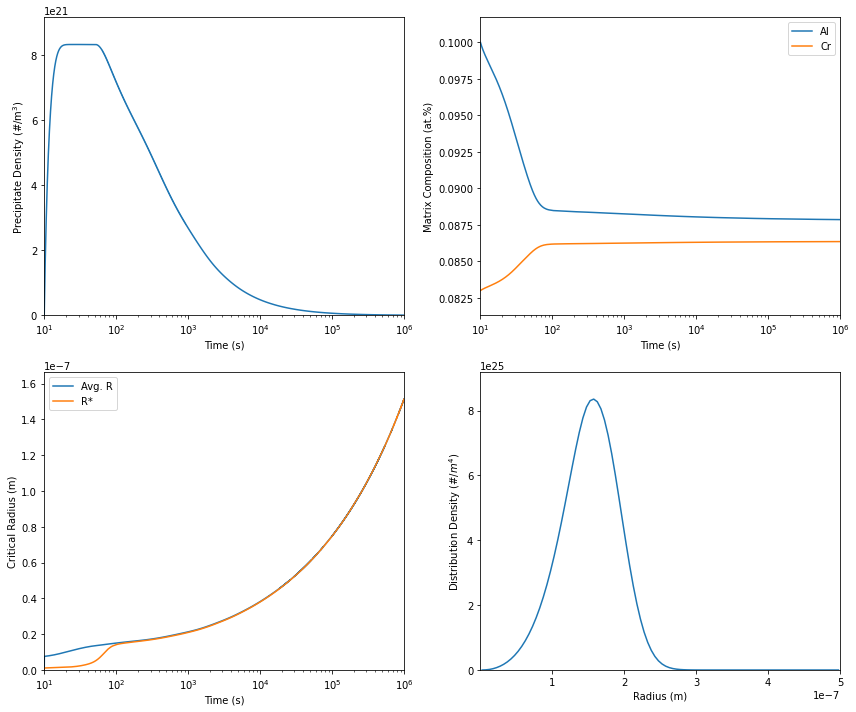

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

model.plot(axes[0,0], 'Precipitate Density')
model.plot(axes[0,1], 'Composition')
model.plot(axes[1,0], 'Average Radius', color='C0', label='Avg. R')
model.plot(axes[1,0], 'Critical Radius', color='C1', label='R*')
axes[1,0].legend(loc='upper left')
model.plot(axes[1,1], 'Size Distribution Density', color='C0')

fig.tight_layout()

## References

1. A. T. Dinsdale, "SGTE Data for Pure Elements" *Calphad* **15** (1991) p. 317
2. N. Dupin, I. Ansara and B. Sundman, "Thermodynamic Re-assessment of the Ternary System Al-Cr-Ni" *Calphad* **25** (2001) p. 279
3. A. Engstrom and J. Agren, "Assessment of Diffusional Mobilities in Face-centered Cubic Ni-Cr-Al Alloys" *Z. Metallkd.* **87** (1996) p. 92